# Исследование минимумов на графики энтропии от времени

In [1]:
import joblib
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import qutip
from tqdm import tqdm

In [2]:
import sys
import pathlib

sys.path.append(str(pathlib.Path(sys.path[0]).parent / "libs"))

In [3]:
%reload_ext autoreload
%autoreload 2

import bec
import entanglement_propagation
from tools.jupyter import print_model_info
from tools.qutip import TqdmProgressBar

## Сравнение графиков энтропии для пары кубитов с разными количеством базонов 

### Двухкубитная цепочка

100%|█████████████| 301/301 [02:52<00:00,  1.75it/s, n150m2;teor;focked;reduced]


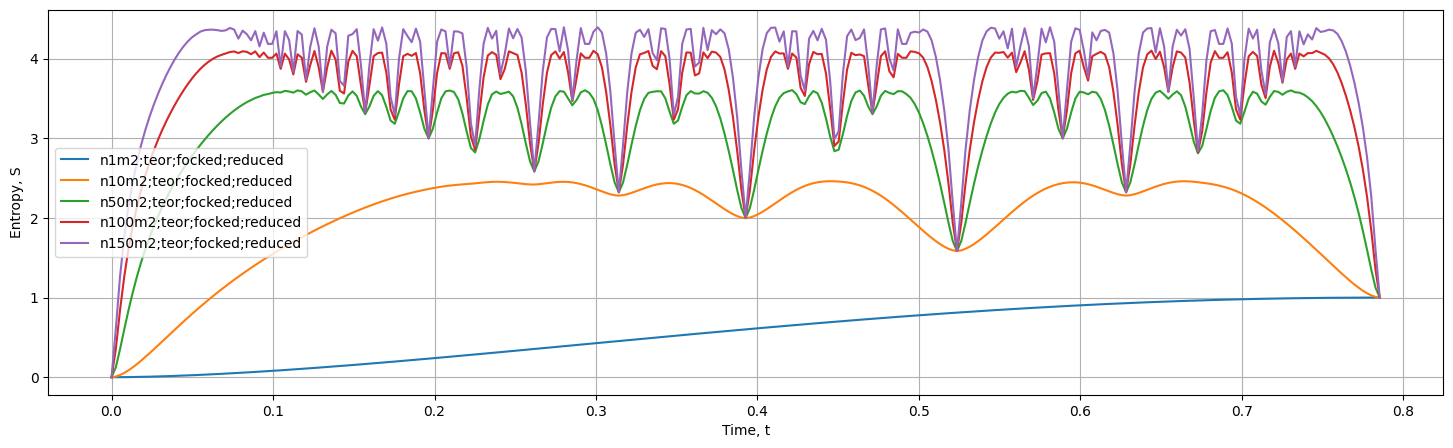

In [4]:
n_jobs = -2

fig, ax = plt.subplots(1, 1, figsize=(18, 5))
tspan = np.linspace(0, np.pi / 4, 301)

for n_bosons in [1, 10, 50, 100, 150]:#, 250]:
    model_ = bec.BEC_Qubits.init_default(n_bosons, 0)
    label = f"n{model_.n_bosons}m2;teor;focked;reduced"
    states_reduced_focked_exact = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(bec.state_under_h_zz_reduced_teor_focked)(model_, t / model_.Omega) 
        for t in tqdm(tspan, ncols=80, postfix=label)
    )
    entropies_reduced_focked_exact = [qutip.entropy.entropy_vn(s, base=2) for s in states_reduced_focked_exact]
    ax.plot(tspan, entropies_reduced_focked_exact, "-", label=label)

ax.set_xlabel("Time, t")
ax.set_ylabel("Entropy, S")
ax.grid()
ax.legend()

In [5]:
%%time

pe_task = entanglement_propagation.PropagateEntanglementTask(
    n_bosons=4,
    n_sites=2,
    t_span=(0, 0.8, 100),
)
pe_result = pe_task.run(n_jobs=1)

model_ = bec.BEC_Qubits.init_default(pe_task.n_bosons, 0)
states_exact = [qutip.ptrace(bec.state_under_h_zz_teor(model_, t / model_.Omega), [2, 3]) for t in tqdm(pe_result.t_list, ncols=80)]
states_focked_exact = [qutip.ptrace(bec.state_under_h_zz_teor_focked(model_, t / model_.Omega), [0]) for t in tqdm(pe_result.t_list, ncols=80)]
states_reduced_focked_exact = [bec.state_under_h_zz_reduced_teor_focked(model_, t / model_.Omega) for t in tqdm(pe_result.t_list, ncols=80)]

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 311.26it/s]

CPU times: user 1.33 s, sys: 85.9 ms, total: 1.41 s
Wall time: 1.43 s


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 48.90it/s]
100it [00:00, 714.89it/s]


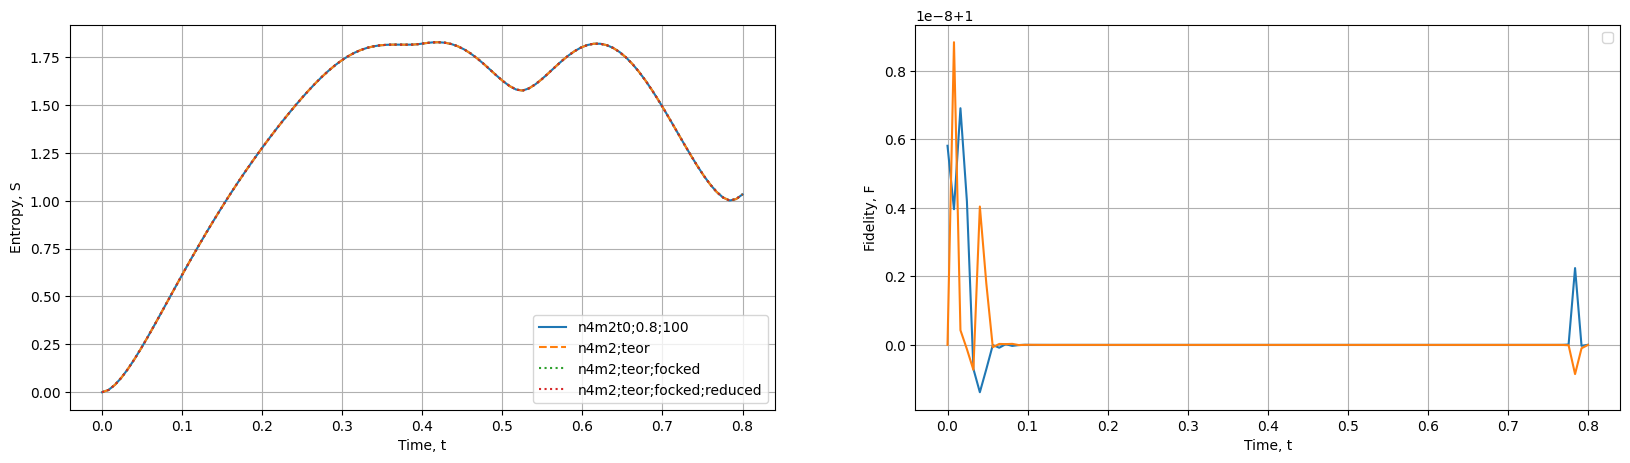

In [6]:
entropies = pe_result.entropies()
entropies_exact = [qutip.entropy.entropy_vn(s, base=2) for s in tqdm(states_exact, ncols=80)]
entropies_focked_exact = [qutip.entropy.entropy_vn(s, base=2) for s in tqdm(states_focked_exact, ncols=80)]
entropies_reduced_focked_exact = [qutip.entropy.entropy_vn(s, base=2) for s in tqdm(states_reduced_focked_exact, ncols=80)]


fig, axes = plt.subplots(1, 2, figsize=(20, 5))

ax = axes[0]
ax.plot(pe_result.t_list, entropies, label=pe_task.label)
ax.plot(pe_result.t_list, entropies_exact, "--", label=f"n{model_.n_bosons}m2;teor")
ax.plot(pe_result.t_list, entropies_focked_exact, ":", label=f"n{model_.n_bosons}m2;teor;focked")
ax.plot(pe_result.t_list, entropies_reduced_focked_exact, ":", label=f"n{model_.n_bosons}m2;teor;focked;reduced")


ax.set_xlabel("Time, t")
ax.set_ylabel("Entropy, S")
ax.grid()
ax.legend()


fids1 = [qutip.metrics.fidelity(pe_result.reveal_state(i), s_e) for i, s_e in enumerate(tqdm(states_exact, ncols=80))]
fids2 = [qutip.metrics.fidelity(s1, s1) for s1, s2 in tqdm(zip(states_exact, states_reduced_focked_exact), ncols=80)]


ax = axes[1]
ax.plot(pe_result.t_list, fids1)
ax.plot(pe_result.t_list, fids2)

ax.set_xlabel("Time, t")
ax.set_ylabel("Fidelity, F")
ax.grid()
ax.legend()

## Пример матрицы плотности в пространстве операторов $а$ и $b$

В дейстительности не нулевыми элементами являются только фоковские состояния. 
Не нулевые элементы укладываются в матрицу $N+1$, вместо $2*(N + 1)$

In [7]:
import sympy as sp
m = bec.BEC_Qubits.init_default(3, 0) 
s = qutip.ptrace(bec.state_under_h_zz_teor(m, 0.4 / m.Omega), [0, 1])
sp.Matrix(s).evalf(3)

Matrix([
[0, 0, 0,                     0, 0, 0,                     0, 0, 0,                     0, 0, 0,                     0, 0, 0, 0],
[0, 0, 0,                     0, 0, 0,                     0, 0, 0,                     0, 0, 0,                     0, 0, 0, 0],
[0, 0, 0,                     0, 0, 0,                     0, 0, 0,                     0, 0, 0,                     0, 0, 0, 0],
[0, 0, 0,    0.125 - 1.35e-18*I, 0, 0,   0.0732 + 4.99e-18*I, 0, 0, -5.39e-6 - 1.52e-18*I, 0, 0,  -0.0501 + 1.35e-18*I, 0, 0, 0],
[0, 0, 0,                     0, 0, 0,                     0, 0, 0,                     0, 0, 0,                     0, 0, 0, 0],
[0, 0, 0,                     0, 0, 0,                     0, 0, 0,                     0, 0, 0,                     0, 0, 0, 0],
[0, 0, 0,   0.0732 + 1.68e-18*I, 0, 0,    0.375 - 8.98e-19*I, 0, 0,    0.127 - 1.99e-17*I, 0, 0, -5.39e-6 - 5.15e-18*I, 0, 0, 0],
[0, 0, 0,                     0, 0, 0,                     0, 0, 0,              

## Цепочки разной длины

### Исследуем след матриц

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 50.29it/s]


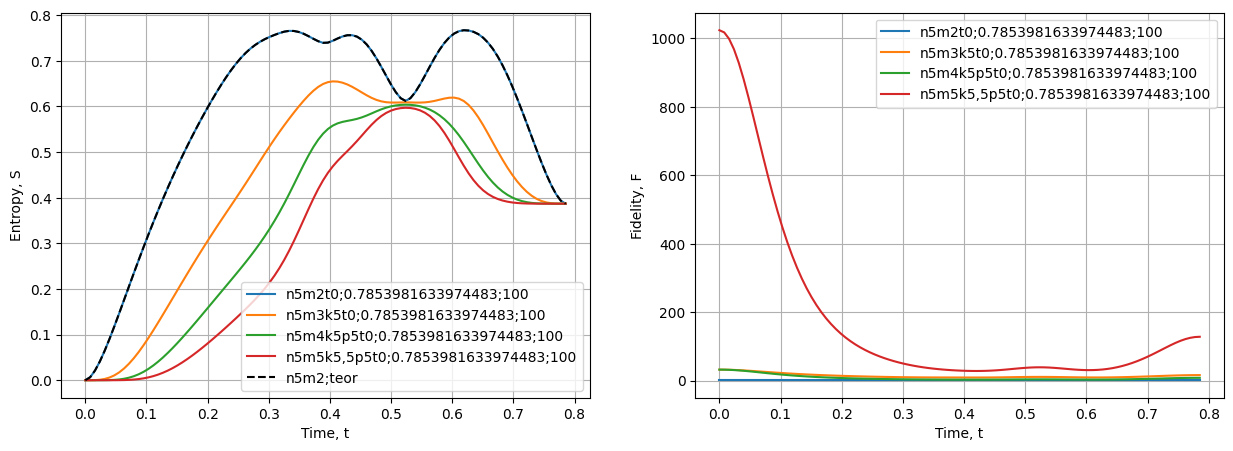

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for m in [2, 3, 4, 5]:
    pe_task = entanglement_propagation.PropagateEntanglementTask(
        n_bosons=5,
        n_sites=m,
        t_span=(0, np.pi / 4, 100),
    )
    model_ = bec.BEC_Qubits.init_default(pe_task.n_bosons, 0)
    
    pe_result = pe_task.run()
    traces = [pe_result.reveal_state(i).tr() for i, _ in enumerate(tqdm(pe_result.t_list, ncols=80))]
   
    axes[0].plot(pe_result.t_list, pe_result.entropies() / np.log2(pe_task.n_bosons + 1), label=pe_task.label)
    axes[1].plot(pe_result.t_list, traces, label=pe_task.label)
    

model_ = bec.BEC_Qubits.init_default(pe_task.n_bosons, 0)
axes[0].plot(
    pe_result.t_list, 
    [
        qutip.entropy.entropy_vn(qutip.ptrace(s, [0, 1]), base=2) / np.log2(pe_task.n_bosons + 1)
        for s in (bec.state_under_h_zz_teor(model_, t / model_.Omega) for t in tqdm(pe_result.t_list, ncols=80))
    ],
    "--k",
    label=f"n{model_.n_bosons}m2;teor"
)

axes[0].set_xlabel("Time, t")
axes[0].set_ylabel("Entropy, S")
axes[0].grid()
axes[0].legend()


axes[1].set_xlabel("Time, t")
axes[1].set_ylabel("Fidelity, F")
axes[1].grid()
axes[1].legend()

### Энтропия и фиделити

#### Производит расчеты в тензорном произведении пространств уровней $a$ и $b$
Использует раскрытие (reveal) фоковского базиса

100%|███| 301/301 [00:32<00:00,  9.15it/s, n15m4k15p15t0;0.7853981633974483;301]
100%|█| 301/301 [00:38<00:00,  7.78it/s, n15m4k15p15t0;0.7853981633974483;301;fi
100%|█| 301/301 [00:27<00:00, 11.13it/s, n15m5k15,15p15t0;0.7853981633974483;301
100%|█| 301/301 [00:39<00:00,  7.69it/s, n15m5k15,15p15t0;0.7853981633974483;301


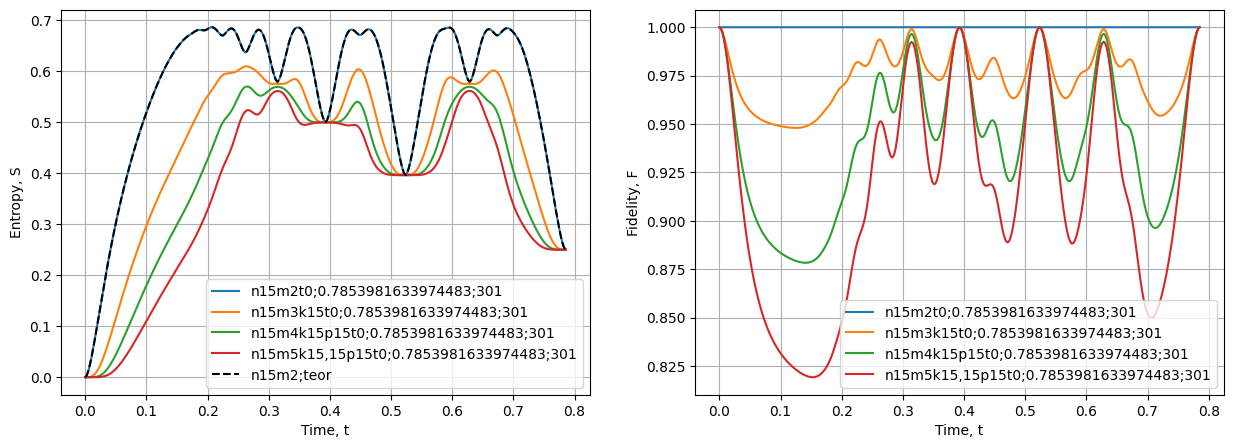

In [9]:
n_bosons = 15
t_span = (0, np.pi / 4, 301)

n_jobs = -2

t_list = np.linspace(*t_span)
model_ = bec.BEC_Qubits.init_default(n_bosons, 0)
states_true = joblib.Parallel(n_jobs=n_jobs)(
    joblib.delayed(lambda t, m: qutip.ptrace(bec.state_under_h_zz_teor(m, t / m.Omega), [0, 1]))(t, model_)
    for t in tqdm(t_list, postfix=f"n{model_.n_bosons}m2;teor", ncols=80)
)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for m in [2, 3, 4, 5]:# , 6, 7]:
    pe_task = entanglement_propagation.PropagateEntanglementTask(
        n_bosons=n_bosons,
        n_sites=m,
        t_span=t_span,
    )
    pe_result = pe_task.run(n_jobs=n_jobs)
    fids = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(lambda i, s_e: qutip.metrics.fidelity((x := pe_result.reveal_state(i)) / x.tr(), s_e))(i, s_e) 
        for i, s_e in enumerate(tqdm(states_true, postfix=f"{pe_task.label};fids", ncols=80))
    )
   
    axes[0].plot(pe_result.t_list, pe_result.entropies() / np.log2(pe_task.n_bosons + 1), label=pe_task.label)
    axes[1].plot(pe_result.t_list, fids, label=pe_task.label)
    

model_ = bec.BEC_Qubits.init_default(pe_task.n_bosons, 0)
axes[0].plot(
    pe_result.t_list, [qutip.entropy.entropy_vn(s, base=2) / np.log2(pe_task.n_bosons + 1) for s in states_true],
    "--k",
    label=f"n{model_.n_bosons}m2;teor"
)

axes[0].set_xlabel("Time, t")
axes[0].set_ylabel("Entropy, S")
axes[0].grid()
axes[0].legend()


axes[1].set_xlabel("Time, t")
axes[1].set_ylabel("Fidelity, F")
axes[1].grid()
axes[1].legend()

#### Производит рассчеты в фоковском базисе

100%|███| 301/301 [00:26<00:00, 11.33it/s, n15m4k15p15t0;0.7853981633974483;301]
100%|█| 301/301 [00:05<00:00, 54.04it/s, n15m4k15p15t0;0.7853981633974483;301;fi
100%|█| 301/301 [00:24<00:00, 12.48it/s, n15m5k15,15p15t0;0.7853981633974483;301
100%|█| 301/301 [00:05<00:00, 51.54it/s, n15m5k15,15p15t0;0.7853981633974483;301


Text(0, 0.5, 'Fidelity, F')

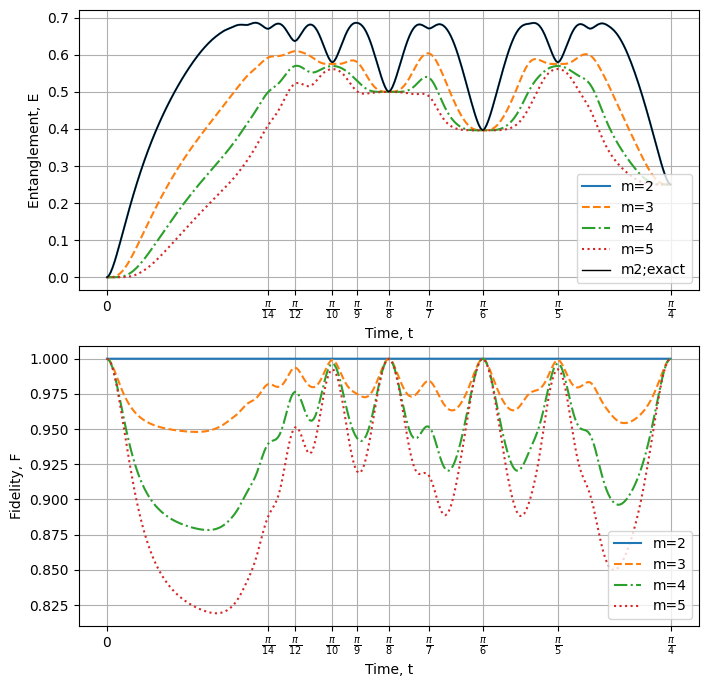

In [10]:
plot_exact = True

n_bosons = 15
t_span = (0, np.pi / 4, 301)

n_jobs = -2

t_list = np.linspace(*t_span)
model_ = bec.BEC_Qubits.init_default(n_bosons, 0)
states_true = joblib.Parallel(n_jobs=n_jobs)(
    joblib.delayed(lambda t, m: bec.state_under_h_zz_reduced_teor_focked(m, t / m.Omega))(t, model_)
    for t in tqdm(t_list, postfix=f"n{model_.n_bosons}m2;teor", ncols=80)
)

linestyles =["-", "--", "-.", ":" ]
numbers_sites = [2, 3, 4, 5, 6, 7]
numbers_sites = [2, 3, 4, 5]
# numbers_sites = []

# fig, axes = plt.subplots(2, 1, figsize=(16, 14))
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

for m, ls in zip(numbers_sites, linestyles):
    pe_task = entanglement_propagation.PropagateEntanglementTask(
        n_bosons=n_bosons,
        n_sites=m,
        t_span=t_span,
    )
    pe_result = pe_task.run(n_jobs=n_jobs)
    fids = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(lambda s, s_e: qutip.metrics.fidelity((sq := pe_result.to_Qobj(s)) / sq.tr(), s_e))(s, s_e) 
        for s, s_e in tqdm(zip(pe_result.states, states_true), postfix=f"{pe_task.label};fids", ncols=80, total=len(pe_result.states))
    )

    label = pe_task.label
    label = f"m={pe_task.n_sites}"
    axes[0].plot(pe_result.t_list, pe_result.entropies() / np.log2(pe_task.n_bosons + 1), linestyle=ls, label=label)
    axes[1].plot(pe_result.t_list, fids, linestyle=ls, label=label)
    

if plot_exact:
    axes[0].plot(
        t_list, [qutip.entropy.entropy_vn(s, base=2) / np.log2(pe_task.n_bosons + 1) for s in states_true],
        "-k",
        label=f"m2;exact",
        linewidth=1
    )

for ax in axes:
    ax.grid()
    ax.legend(loc="lower right")
    ax.set_xlabel("Time, t")
    ax.set_xticks(*zip(*(
        (
            (np.pi / i, rf"$\frac{{\pi}}{{{i}}}$") 
            if i != 0 else 
            (0, "0")
        ) 
        if isinstance(i, int) else 
        (i[0] * np.pi / i[1], rf"$\frac{{{i[0]}\pi}}{{{i[1]}}}$")  
        for i in (0, 14, 12, 10, 9, 8, 7, 6, 5, 4))))

axes[0].set_ylabel("Entanglement, E")
axes[1].set_ylabel("Fidelity, F")

In [ ]:
fig.savefig("/Users/kephircheek/Desktop/lindsey.pdf")

In [ ]:
fig.tight_layout()
for i, ext in enumerate(fig.get_window_extent().transformed(fig.dpi_scale_trans.inverted()).splity(0.5)):
    if i != 1: continue
    fig.savefig(f"../assets/{('fidelity', 'entanglement')[i]}_n{n_bosons}.eps", bbox_inches=ext)

## Построение графиков на основе готовых расчетов

In [25]:
!ls -1t ../assets/scripts/propagate_entanglement/results/

n30m5k30,0p29t0;0.7853981633974483;301.json
n30m5k30,0p0t0;0.7853981633974483;301.json
n30m5k30,30p30t0;0.7853981633974483;301.json
n30m5k30,30p29t0;0.7853981633974483;301.json
n30m5k30,30p0t0;0.7853981633974483;301.json
n3m5k2,3p3t0;0.7853981633974483;301.json
n3m5k2,3p2t0;0.7853981633974483;301.json
n3m5k0,0p0t0;0.7853981633974483;301.json
n3m5k3,0p2t0;0.7853981633974483;301.json
n3m5k3,0p3t0;0.7853981633974483;301.json
n3m5k2,2p0t0;0.7853981633974483;301.json
n3m5k2,3p0t0;0.7853981633974483;301.json
n3m5k2,2p3t0;0.7853981633974483;301.json
n3m5k2,2p2t0;0.7853981633974483;301.json
n3m5k0,0p3t0;0.7853981633974483;301.json
n3m5k0,0p2t0;0.7853981633974483;301.json
n3m5k3,0p0t0;0.7853981633974483;301.json
n3m5k3,3p3t0;0.7853981633974483;301.json
n3m5k3,3p2t0;0.7853981633974483;301.json
n3m5k3,3p0t0;0.7853981633974483;301.json
n30m7k30,30,30p30t0;0.7853981633974483;501.json
n30m6k30,30p30t0;0.7853981633974483;501.json
n30m4k30p30t0;0.7853981633974483;501.json
n30m5k30,30p30t0;0.7853981633

### 30 бозонов; Все результаты измерения равны числу бозонов; Варьируется размер цепочки;  

100%|█| 501/501 [02:35<00:00,  3.21it/s, n30m3k30t0;0.7853981633974483;501;fids]
100%|█| 501/501 [02:31<00:00,  3.30it/s, n30m4k30p30t0;0.7853981633974483;501;fi
100%|█| 501/501 [05:24<00:00,  1.54it/s, n30m5k30,30p30t0;0.7853981633974483;501
100%|█| 501/501 [02:29<00:00,  3.36it/s, n30m6k30,30p30t0;0.7853981633974483;501
100%|█| 501/501 [02:38<00:00,  3.16it/s, n30m7k30,30,30p30t0;0.7853981633974483;


Text(0, 0.5, 'Fidelity, F')

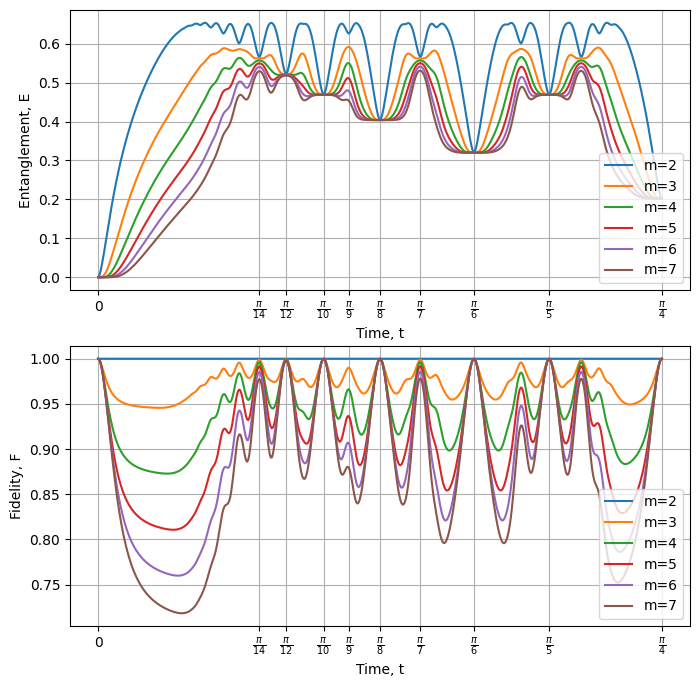

In [71]:
plot_exact = False

n_jobs = -2
n_bosons = 30
t_span = (0, np.pi / 4, 501)

t_list = np.linspace(*t_span)
model_ = bec.BEC_Qubits.init_default(n_bosons, 0)
states_true = joblib.Parallel(n_jobs=n_jobs)(
    joblib.delayed(lambda t, m: bec.state_under_h_zz_reduced_teor_focked(m, t / m.Omega))(t, model_)
    for t in tqdm(t_list, postfix=f"n{model_.n_bosons}m2;teor", ncols=80)
)

linestyles =["-", "--", "-.", ":", (0, (5, 5)), (0, (3, 5, 1, 5))]
linestyles = ["-"] * 10
numbers_sites = [2, 3, 4, 5, 6, 7]
# numbers_sites = [2, 3, 4, 5]
# numbers_sites = []

results_path = pathlib.Path("../assets/scripts/propagate_entanglement/results/")

# fig, axes = plt.subplots(2, 1, figsize=(16, 14))
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

for i, m in enumerate(numbers_sites):
    ls = linestyles[i]
    pe_task = entanglement_propagation.PropagateEntanglementTask(
        n_bosons=n_bosons,
        n_sites=m,
        t_span=t_span,
    )
    with open(results_path / f"{pe_task.label}.json") as f:
        pe_result = entanglement_propagation.PropagateEntanglementResult.load(f)
        
    # pe_result = pe_task.run(n_jobs=n_jobs)
    fids = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(lambda s, s_e: qutip.metrics.fidelity((sq := pe_result.to_Qobj(s)) / sq.tr(), s_e))(s, s_e) 
        for s, s_e in tqdm(zip(pe_result.states, states_true), postfix=f"{pe_task.label};fids", ncols=80, total=len(pe_result.states))
    )

    label = pe_task.label
    label = f"m={pe_task.n_sites}"
    axes[0].plot(pe_result.t_list, pe_result.entropies() / np.log2(pe_task.n_bosons + 1), linestyle=ls, label=label)
    axes[1].plot(pe_result.t_list, fids, linestyle=ls, label=label)
    

if plot_exact:
    axes[0].plot(
        t_list, [qutip.entropy.entropy_vn(s, base=2) / np.log2(pe_task.n_bosons + 1) for s in states_true],
        "-k",
        label=f"m2;exact",
        linewidth=1
    )

for ax in axes:
    ax.grid()
    ax.legend(loc="lower right")
    ax.set_xlabel("Time, t")
    ax.set_xticks(*zip(*(
        (
            (np.pi / i, rf"$\frac{{\pi}}{{{i}}}$") 
            if i != 0 else 
            (0, "0")
        ) 
        if isinstance(i, int) else 
        (i[0] * np.pi / i[1], rf"$\frac{{{i[0]}\pi}}{{{i[1]}}}$")  
        for i in (0, 14, 12, 10, 9, 8, 7, 6, 5, 4))))

axes[0].set_ylabel("Entanglement, E")
axes[1].set_ylabel("Fidelity, F")


In [ ]:
fig.tight_layout()
for i, ext in enumerate(fig.get_window_extent().transformed(fig.dpi_scale_trans.inverted()).splity(0.5)):
    fig.savefig(f"../assets/{('fidelity', 'entanglement')[i]}_n{n_bosons}.eps", bbox_inches=ext)

### Разные результаты измерения

100%|█████████████████████████████| 301/301 [00:04<00:00, 60.26it/s, n30m2;teor]
100%|█| 301/301 [00:45<00:00,  6.68it/s, n30m5k30,30p0t0;0.7853981633974483;301;
100%|█| 301/301 [00:47<00:00,  6.27it/s, n30m5k30,30p29t0;0.7853981633974483;301
100%|█| 301/301 [00:50<00:00,  5.95it/s, n30m5k30,30p30t0;0.7853981633974483;301
100%|█| 301/301 [00:56<00:00,  5.36it/s, n30m5k30,0p0t0;0.7853981633974483;301;f
100%|█| 301/301 [00:49<00:00,  6.02it/s, n30m5k30,0p29t0;0.7853981633974483;301;
100%|█| 301/301 [00:52<00:00,  5.73it/s, n30m5k30,0p30t0;0.7853981633974483;301;
100%|█| 301/301 [00:55<00:00,  5.45it/s, n30m5k0,0p0t0;0.7853981633974483;301;fi
100%|█| 301/301 [00:56<00:00,  5.32it/s, n30m5k0,0p29t0;0.7853981633974483;301;f
100%|█| 301/301 [00:52<00:00,  5.73it/s, n30m5k0,0p30t0;0.7853981633974483;301;f


not found: n30m5k29,29p0t0;0.7853981633974483;301
not found: n30m5k29,29p29t0;0.7853981633974483;301
not found: n30m5k29,29p30t0;0.7853981633974483;301
not found: n30m5k29,30p0t0;0.7853981633974483;301
not found: n30m5k29,30p29t0;0.7853981633974483;301
not found: n30m5k29,30p30t0;0.7853981633974483;301


Text(0, 0.5, 'Fidelity, F')

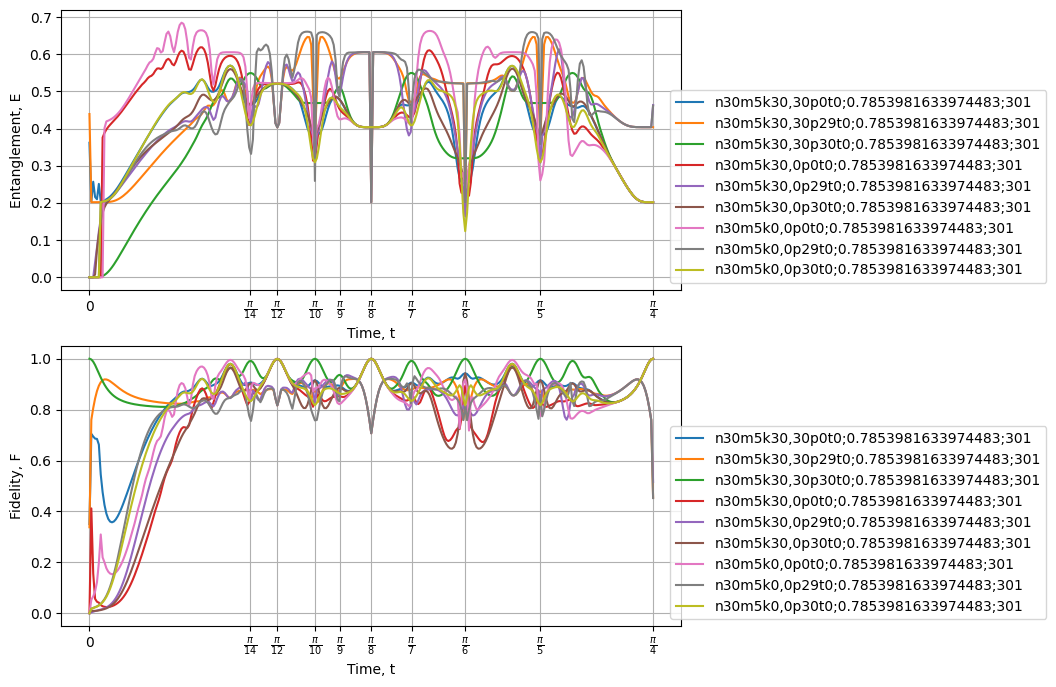

In [6]:
import itertools

n_jobs = -2
n_bosons = 30
t_span = (0, np.pi / 4, 301)

t_list = np.linspace(*t_span)
model_ = bec.BEC_Qubits.init_default(n_bosons, 0)
states_true = joblib.Parallel(n_jobs=n_jobs)(
    joblib.delayed(lambda t, m: bec.state_under_h_zz_reduced_teor_focked(m, t / m.Omega))(t, model_)
    for t in tqdm(t_list, postfix=f"n{model_.n_bosons}m2;teor", ncols=80)
)

# linestyles =["-", "--", "-.", ":", (0, (5, 5)), (0, (3, 5, 1, 5))]
numbers_sites = [5]
k_measured_sets = [
    (n_bosons, n_bosons),
    (n_bosons, 0),
    (0, 0),
    (n_bosons - 1, n_bosons - 1),
    (n_bosons - 1, n_bosons),
]
projections = [
    0, 
    n_bosons - 1, 
    n_bosons
]


results_path = pathlib.Path("../assets/scripts/propagate_entanglement/results/")


fig, axes = plt.subplots(2, 1, figsize=(8, 8))

for i, (m, k_measured, projection) in enumerate(itertools.product(numbers_sites, k_measured_sets, projections)):
    # ls = linestyles[i]
    ls = None
    pe_task = entanglement_propagation.PropagateEntanglementTask(
        n_bosons=n_bosons,
        n_sites=m,
        t_span=t_span,
        k_measured=k_measured,
        projection=projection,
        
    )
    try: 
        with open(results_path / f"{pe_task.label}.json") as f:
            pe_result = entanglement_propagation.PropagateEntanglementResult.load(f)
    except FileNotFoundError:
        print(f"not found: {pe_task.label}")
        continue


   
    fids = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(
            lambda s, s_e: 
                qutip.metrics.fidelity(sq / sq.tr(), s_e) 
                if (sq := pe_result.to_Qobj(s)).tr() > 0 
                else 0
        )(s, s_e) 
        for s, s_e in tqdm(
            zip(pe_result.states, states_true), 
            postfix=f"{pe_task.label};fids", 
            ncols=80, 
            total=len(pe_result.states),
            # disable=True,
        )
    )   
    
    label = pe_task.label
    # label = f"m={pe_task.n_sites}"
    axes[0].plot(pe_result.t_list, pe_result.entropies() / np.log2(pe_task.n_bosons + 1), linestyle=ls, label=label)
    axes[1].plot(pe_result.t_list, fids, linestyle=ls, label=label) 
    
for ax in axes:
    ax.grid()
    ax.legend(loc="lower right", bbox_to_anchor=(1.6, 0))
    ax.set_xlabel("Time, t")
    ax.set_xticks(*zip(*(
        (
            (np.pi / i, rf"$\frac{{\pi}}{{{i}}}$") 
            if i != 0 else 
            (0, "0")
        ) 
        if isinstance(i, int) else 
        (i[0] * np.pi / i[1], rf"$\frac{{{i[0]}\pi}}{{{i[1]}}}$")  
        for i in (0, 14, 12, 10, 9, 8, 7, 6, 5, 4))))

axes[0].set_ylabel("Entanglement, E")
axes[1].set_ylabel("Fidelity, F")


### PI / 8

100%|█████████| 201/201 [00:02<00:00, 81.57it/s, n15m5k1,0p0t0.35;0.45;201;fids]


256/4096 done!


100%|█████████| 201/201 [00:02<00:00, 85.74it/s, n15m5k1,0p1t0.35;0.45;201;fids]


257/4096 done!


100%|█████████| 201/201 [00:02<00:00, 77.08it/s, n15m5k1,0p2t0.35;0.45;201;fids]


258/4096 done!


100%|████████| 201/201 [00:02<00:00, 76.45it/s, n15m5k1,0p13t0.35;0.45;201;fids]


269/4096 done!


100%|████████| 201/201 [00:02<00:00, 68.56it/s, n15m5k1,0p14t0.35;0.45;201;fids]


270/4096 done!


100%|████████| 201/201 [00:02<00:00, 84.87it/s, n15m5k1,0p15t0.35;0.45;201;fids]


271/4096 done!


100%|█████████| 201/201 [00:02<00:00, 81.79it/s, n15m5k2,1p0t0.35;0.45;201;fids]


528/4096 done!


100%|█████████| 201/201 [00:02<00:00, 77.07it/s, n15m5k2,1p1t0.35;0.45;201;fids]


529/4096 done!


100%|█████████| 201/201 [00:02<00:00, 80.16it/s, n15m5k2,1p2t0.35;0.45;201;fids]


530/4096 done!


100%|████████| 201/201 [00:02<00:00, 85.11it/s, n15m5k2,1p13t0.35;0.45;201;fids]


541/4096 done!


100%|████████| 201/201 [00:02<00:00, 83.32it/s, n15m5k2,1p14t0.35;0.45;201;fids]


542/4096 done!


100%|████████| 201/201 [00:02<00:00, 74.27it/s, n15m5k2,1p15t0.35;0.45;201;fids]


543/4096 done!


100%|█████████| 201/201 [00:02<00:00, 67.30it/s, n15m5k2,5p0t0.35;0.45;201;fids]


592/4096 done!


100%|█████████| 201/201 [00:03<00:00, 64.33it/s, n15m5k2,5p1t0.35;0.45;201;fids]


593/4096 done!


100%|█████████| 201/201 [00:03<00:00, 62.90it/s, n15m5k2,5p2t0.35;0.45;201;fids]


594/4096 done!


100%|████████| 201/201 [00:02<00:00, 83.13it/s, n15m5k2,5p13t0.35;0.45;201;fids]


605/4096 done!


100%|████████| 201/201 [00:02<00:00, 77.48it/s, n15m5k2,5p14t0.35;0.45;201;fids]


606/4096 done!


100%|████████| 201/201 [00:02<00:00, 82.58it/s, n15m5k2,5p15t0.35;0.45;201;fids]


607/4096 done!


100%|█████████| 201/201 [00:02<00:00, 70.49it/s, n15m5k4,9p0t0.35;0.45;201;fids]


1168/4096 done!


100%|█████████| 201/201 [00:02<00:00, 79.54it/s, n15m5k4,9p1t0.35;0.45;201;fids]


1169/4096 done!


100%|█████████| 201/201 [00:02<00:00, 83.07it/s, n15m5k4,9p2t0.35;0.45;201;fids]


1170/4096 done!


100%|████████| 201/201 [00:04<00:00, 42.52it/s, n15m5k4,9p13t0.35;0.45;201;fids]


1181/4096 done!


100%|████████| 201/201 [00:04<00:00, 46.11it/s, n15m5k4,9p14t0.35;0.45;201;fids]


1182/4096 done!


100%|████████| 201/201 [00:03<00:00, 55.31it/s, n15m5k4,9p15t0.35;0.45;201;fids]


1183/4096 done!


100%|█████████| 201/201 [00:03<00:00, 60.73it/s, n15m5k7,8p0t0.35;0.45;201;fids]


1920/4096 done!


100%|█████████| 201/201 [00:03<00:00, 60.14it/s, n15m5k7,8p1t0.35;0.45;201;fids]


1921/4096 done!


100%|█████████| 201/201 [00:03<00:00, 57.27it/s, n15m5k7,8p2t0.35;0.45;201;fids]


1922/4096 done!


100%|████████| 201/201 [00:03<00:00, 52.98it/s, n15m5k7,8p13t0.35;0.45;201;fids]


1933/4096 done!


100%|████████| 201/201 [00:03<00:00, 52.66it/s, n15m5k7,8p14t0.35;0.45;201;fids]


1934/4096 done!


100%|████████| 201/201 [00:03<00:00, 53.65it/s, n15m5k7,8p15t0.35;0.45;201;fids]


1935/4096 done!
Missed 3570 files


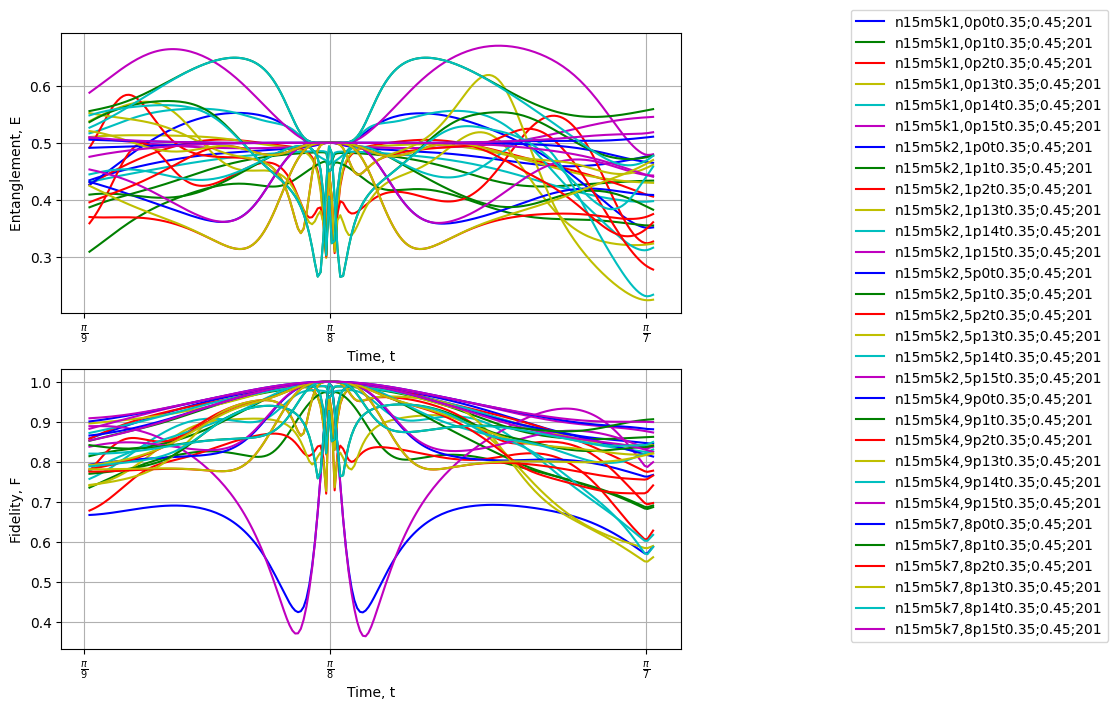

In [68]:
import itertools

n_jobs = -2
n_bosons = 15
t_span = (0.35, 0.45, 201)

t_list = np.linspace(*t_span)
model_ = bec.BEC_Qubits.init_default(n_bosons, 0)
states_true = joblib.Parallel(n_jobs=n_jobs)(
    joblib.delayed(lambda t, m: bec.state_under_h_zz_reduced_teor_focked(m, t / m.Omega))(t, model_)
    for t in tqdm(t_list, postfix=f"n{model_.n_bosons}m2;teor", ncols=80)
)

# linestyles =["-", "--", "-.", ":", (0, (5, 5)), (0, (3, 5, 1, 5))]
numbers_sites = [5]
k_measured_sets = itertools.product(range(0, n_bosons + 1), range(0, n_bosons + 1))
# k_measured_sets = [
    # (n_bosons, n_bosons),
    # (n_bosons, 0),
    # (0, 0),
    # (n_bosons - 1, n_bosons - 1),
    # (n_bosons - 1, n_bosons),
# ]
# projections = [
#     0, 
#     n_bosons - 1, 
#     n_bosons
# ]
projections = list(range(0, n_bosons + 1, 1))

results_path = pathlib.Path("../assets/scripts/propagate_entanglement/results/")
n_missed_files = 0

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
cases = list(enumerate(itertools.product(numbers_sites, k_measured_sets, projections)))
for i, (m, k_measured, projection) in cases:
    if projection == 3: continue
    # if k_measured != (n_bosons, n_bosons): continue
    # if k_measured == (n_bosons, n_bosons): continue
    # if k_measured != (0, 0): continue
    # if k_measured != (n_bosons, 0): continue
    # if k_measured != (n_bosons - 1, n_bosons - 1): continue
    if k_measured[0] == k_measured[1]: continue
    # ls = linestyles[i]
    ls = None
    color=None
    pe_task = entanglement_propagation.PropagateEntanglementTask(
        n_bosons=n_bosons,
        n_sites=m,
        t_span=t_span,
        k_measured=k_measured,
        projection=projection,
        
    )
    try: 
        with open(results_path / f"{pe_task.label}.json") as f:
            pe_result = entanglement_propagation.PropagateEntanglementResult.load(f)
    except FileNotFoundError:
        n_missed_files += 1
        #print(f"not found: {pe_task.label}")
        continue


   
    fids = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(
            lambda s, s_e: 
                qutip.metrics.fidelity(sq / sq.tr(), s_e) 
                if (sq := pe_result.to_Qobj(s)).tr() > 0 
                else 0
        )(s, s_e) 
        for s, s_e in tqdm(
            zip(pe_result.states, states_true), 
            postfix=f"{pe_task.label};fids", 
            ncols=80, 
            total=len(pe_result.states),
            # disable=True,
        )
    )   
    
    label = pe_task.label
    # label = f"m={pe_task.n_sites}"
    color = {0: "b", n_bosons: "m", 1: "g", n_bosons - 1: "c", 2: "r", n_bosons - 2: "y"}[pe_task.projection]
    # color = {0: "b", n_bosons: "b", 1: "g", n_bosons - 1: "g", 2: "r", n_bosons - 2: "r"}[pe_task.projection]
    axes[0].plot(pe_result.t_list, pe_result.entropies() / np.log2(pe_task.n_bosons + 1), linestyle=ls, label=label, color=color)
    axes[1].plot(pe_result.t_list, fids, linestyle=ls, label=label, color=color) 
    print(f"{i}/{len(cases)} done!")

for ax in axes:
    ax.grid()
    # ax.legend(loc="lower right", bbox_to_anchor=(1.6, 0))
    ax.set_xlabel("Time, t")
    ax.set_xticks(*zip(*(
        (
            (np.pi / i, rf"$\frac{{\pi}}{{{i}}}$") 
            if i != 0 else 
            (0, "0")
        ) 
        if isinstance(i, int) else 
        (i[0] * np.pi / i[1], rf"$\frac{{{i[0]}\pi}}{{{i[1]}}}$")  
        for i in (9, 8, 7))))


axes[0].set_ylabel("Entanglement, E")
axes[1].set_ylabel("Fidelity, F")
axes[1].legend(loc="lower right", bbox_to_anchor=(1.7, 0))


print(f"Missed {n_missed_files} files")